# Evaluación de modelos, métricas de puntuación y manejo de conjuntos de datos no balanceados.

En los cuadernos anteriores, hemos detallado como evaluar un modelo y como escoger el mejor modelo posible. Hasta ahora, hemos asumido que nos proporcionaban una medida de rendimiento, algo para medir la calidad del modelo. Sin embargo, no siempre está claro cuál debería ser la medida a utilizar.
Por defecto, en scikit-learn, se utiliza el ``accuracy`` para clasificación, que es el ratio de patrones correctamente clasificados y el $R^2$ para regresión, que es el coeficiente de determinación.
Estas medidas son razonables para muchos escenarios. Sin embargo, dependiendo de la tarea que estemos tratando, estas no tienen porque ser las mejores opciones (y a veces pueden ser opciones muy poco recomendables).
Vamos a centrarnos en la tarea de clasificación, volviendo de nuevo al problema de clasificación de dígitos manuscritos. Scikit-learn tiene métodos muy útiles en el paquete ``sklearn.metrics`` para ayudarnos a entrenar un clasificador y luego evaluarlo de distintas formas:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2) #imprimir arrays con n decimales por defecto

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

digits = load_digits()
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=1,
                                                    stratify=y,
                                                    test_size=0.25)

classifier = LinearSVC(random_state=1).fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)

print("CCR: %f"%(classifier.score(X_test, y_test)))

CCR: 0.951111


Vemos que hemos predicho alrededor de un 95% de patrones de forma correcta. Para problemas multi-clase, a veces es muy útil saber qué clases son más difíciles de predecir y cuáles más fáciles o incluso qué tipo de errores son los más comunes. Una forma de tener más información en este sentido es la **matriz de confusión**, que muestra para cada clase (filas) cuántas veces se predicen qué clases (columnas).

In [3]:
from sklearn.metrics import confusion_matrix #construccion matriz de confusion. Problema de digitos, 10 por 10
confusion_matrix(y_test, y_test_pred)

array([[44,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 45,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  1, 43,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 45,  0,  0,  0,  0,  0,  1],
       [ 0,  2,  0,  0, 41,  0,  0,  1,  0,  1],
       [ 0,  1,  0,  0,  0, 42,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  1, 44,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  0, 42,  1,  0],
       [ 0,  4,  0,  1,  0,  0,  0,  0, 37,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 45]])

A veces un gráfico es más fácil de leer:

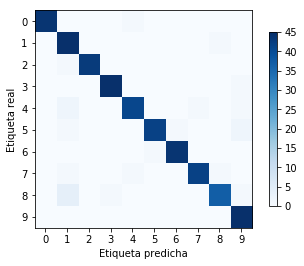

In [4]:
plt.imshow(confusion_matrix(y_test, y_test_pred), cmap="Blues")
plt.colorbar(shrink=0.8)
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real");

Podemos ver que la mayoría de valores están en la diagonal principal, lo que significa que predecimos casi todos los ejemplos correctamente. Las entradas que no están en la diagonal principal nos muestran que hay bastantes ochos clasificados como unos, y que los nueves son fácilmente confundibles con el resto de clases.

Otra función muy útil es ``classification_report`` que nos proporciona los valores de precisión, recall, puntuación f y el soporte para todas las clases. La precisión nos dice cuantas de las predicciones de una clase, son realmente de esa clase. Sea TP, FP, TN, FN "true positive" (verdaderos positivos), "false positive", (falsos positivos),"true negative" (verdaderos negativos) y "false negative" (falsos negativos), respectivamente:

Precision = TP / (TP + FP)

El recall representa cuantos ejemplos de la clase fueron clasificados correctamente (accuracy considerando solo esa clase):

Recall = TP / (TP + FN)

El valor F1 es la media geométrica de la precisión y el recall:

F1 = 2 x (precision x recall) / (precision + recall)

Todas estas métricas están en el intervalo $[0,1]$, donde un 1 es una puntuación perfecta.

In [5]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred)) #mira cada clase por separado

             precision    recall  f1-score   support

          0       1.00      0.98      0.99        45
          1       0.83      0.98      0.90        46
          2       1.00      0.98      0.99        44
          3       0.98      0.98      0.98        46
          4       0.95      0.91      0.93        45
          5       0.98      0.91      0.94        46
          6       0.98      0.98      0.98        45
          7       0.98      0.93      0.95        45
          8       0.95      0.86      0.90        43
          9       0.90      1.00      0.95        45

avg / total       0.95      0.95      0.95       450



Estas métricas son especialmente útiles en dos casos particulares:
1. Clasificación no balanceada, es decir, una o varias clases son mucho menos frecuentes (hay menos casos en el conjunto de entrenamiento) que el resto de clases.
2. Costes asimétricos, esto es, algunos tipos de errores son más "costosos" que el resto.

Vamos a ver el primer caso. Imagina que tenemos un ratio de 1:9 para un problema de clasificación (lo cuál no es muy exagerado, piensa por ejemplo en la predicción de clicks sobre banners de publicidad, donde a lo mejor solo un 0.001% de los anunciados son visitados):

In [6]:
np.bincount(y) / y.shape[0] #numero de patrones de cada clase. 10 porciento de cada uno. balanceado

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1])

Para probar este escenario, vamos a clasificar el dígito 3 contra el resto (el problema de clasificación es un problema binario, ¿es este dígito un 3?):

In [7]:
X, y = digits.data, digits.target == 3

Ahora vamos a aplicar validación cruzada con un clasificador para ver que tal funciona:

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

cross_val_score(SVC(), X, y) #aplica directamente un metodo de valicion, un 3 fold. OJO puede ser un clasificador trivial

array([ 0.9,  0.9,  0.9])

Nuestro clasificador tienen un 90% de acierto siempre. ¿Es bueno o malo? Ten en cuenta que el 90% de los dígitos no son un 3. Vamos a ver que tal funciona un clasificador simple, que siempre predice la clase más frecuenta (ZeroR):

In [9]:
from sklearn.dummy import DummyClassifier
cross_val_score(DummyClassifier("most_frequent"), X, y)

array([ 0.9,  0.9,  0.9])

También un 90%, como esperábamos. Por tanto, podemos pensar que el clasificador SVC no es demasiado bueno, ya que funciona igual que una estrategia que ni si quiera mira los datos de entrada. De todas formas, esto sería sacar conclusiones muy rápido ya que, en general, el accuracy no es una buena medida de rendimiento para bases de datos no balanceadas.

In [10]:
np.bincount(y) / y.shape[0]

array([ 0.9,  0.1])

Curvas ROC
=======

Una medida mucho mejor se puede obtener utilizando las llamadas curvas de operación características (ROC, *Receiver operating characteristics*). Una curva ROC trabaja con las medidas de incertidumbre de un clasificador, por ejemplo la función de decisión de un ``SVC``. En lugar de utilizar el cero como umbral para distinguir ejemplos negativos de ejemplos positivos, la curva ROC considera todos los posibles umbrales y almacena el ratio de ejemplos de la clase positiva que se predicen correctamente (TPR) y el ratio de fallos para la clase negativa (FPR).

El siguiente gráfico compara la curva ROC de tres configuraciones distintas de nuestro clasificador para la tarea "tres vs el resto".

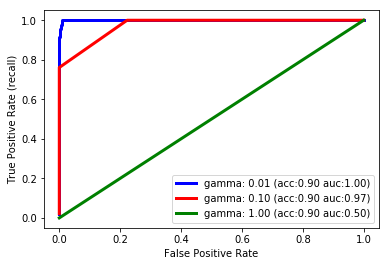

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

color = ['b','r','g']
c = 0

for gamma in [.01, .095, 1]: #SVM no lineal, parametro c y el ancho del kernel
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")
    svm = SVC(gamma=gamma).fit(X_train, y_train)
    decision_function = svm.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, decision_function) #devuelve valores de fpr y tpr para esa curva
    acc = svm.score(X_test, y_test)
    auc = roc_auc_score(y_test, svm.decision_function(X_test))
    plt.plot(fpr, tpr, color=color[c], label="gamma: %.2f (acc:%.2f auc:%.2f)" % (gamma, acc, auc), linewidth=3)
    c = c + 1
plt.legend(loc="best"); #el verde es malo, el mejor es el azul. auc area bajo la curva roc, es la maxima.

Si el valor de umbral es muy bajo, tendremos muchos falsos positivos y por tanto un TPR muy alto y un FPR muy alto (porque casi todo lo clasificamos como positivo). Si usamos un umbral muy alto, habrá muy pocos falsos positivos (casi todo se predice como negativo), y por tanto el TPR será bajo y el FPR también. Por lo que, en general, la curva va desde arriba a la derecha hasta abajo a la izquierda. Una línea diagonal indica que el rendimiento es aleatorio, mientras que el objetivo ideal sería que la curva se desplace arriba a la izquierda. Esto significa que el clasificador daría siempre valores más altos de la función de decisión a los ejemplos positivos que a los ejemplos negativos.

En este sentido, esta curva solo considera el orden asignado a los ejemplos positivos y negativos según la función de decisión, pero no el valor asignado. Como puedes ver a partir de las curvas y de los valores de accuracy, aunque todos los clasificadores tengan el mismo accuracy, uno de ellos tiene una curva ROC perfecta, mientras que otro se comporta igual que un clasificador aleatorio.

Para realizar búsqueda en rejilla y validación cruzada, nos gustaría que la evaluación se guiase por un único valor numérico. Una buena forma de hacer esto es considera el área bajo la curva ROC (*area under the curve*, AUC). Podemos usar esto en ``cross_val_score`` especificando ``scoring="roc_auc"``:

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(SVC(), X, y, scoring="roc_auc")

array([ 1.,  1.,  1.])

Compara el rendimiento con el DummyClassifier:

In [13]:
from sklearn.linear_model import LogisticRegression
cross_val_score(LogisticRegression(), X, y, scoring="roc_auc") 

array([ 0.98,  1.  ,  0.97])

Funciones de rendimiento por defecto y personalizadas
=======================================

Hay muchas medidas de rendimiento, que son útiles para problemas muy distintos. Puedes encontrarlas en el diccionario "SCORERS". La documentación explica todas ellas.

In [14]:
from sklearn.metrics.scorer import SCORERS
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'median_absolute_error', 'mean_absolute_error', 'mean_squared_error', 'accuracy', 'roc_auc', 'average_precision', 'log_loss', 'neg_log_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])


También es posible escribir tu propia medida de rendimiento. En lugar de una cadena, puedes pasar un nombre de función como argumento ``scoring``, esto es, un objeto con un método ``__call__`` (o lo que es lo mismo, una función). Esa función debe recibir un modelo, un conjunto de características ``X_test`` y un conjutno de etiquetas ``y_test``, y devolver un valor real. Los valores más altos deberían indicar que el modelo es mejor.

Para probarlo, vamos a reimplementar la medida estándar de accuracy:

In [15]:
def my_accuracy_scoring(est, X, y):
    return np.mean(est.predict(X) == y)

cross_val_score(SVC(), X, y, scoring=my_accuracy_scoring)

array([ 0.9,  0.9,  0.9])

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      En las secciones anteriores, normalmente usábamos el accuracy para evaluar el rendimiento de nuestros clasificadores. Una medida relacionada de la cuál no hemos hablado aún es el accuracy medio por clase (average-per-class accuracy, APCA). Como recordarás, el accuracy se puede definir como:

$$ACC = \frac{TP+TN}{n},$$

donde *n* es el número total de ejemplos. Esto puede generalizarse para multiclase como:

$$ACC =  \frac{T}{n},$$

donde *T* es el número total de predicciones correctas (diagonal principal).
      </li>
    </ul>
    ![](figures/average-per-class.png)
    <li>
    Dados los siguientes arrays de etiquetas verdaderas y de etiquetas predichas, ¿puedes implementar una función que utilice la métrica accuracy para conseguir el APCA?
    </li>
</div>

In [23]:
y_true = np.array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2])
y_pred = np.array([0, 1, 1, 0, 1, 1, 2, 2, 2, 2])

confusion_matrix(y_true, y_pred)

array([[1, 2, 0],
       [1, 2, 2],
       [0, 0, 2]])

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import numpy as np

print("Precisión",accuracy_score(y_true, y_pred))


Precisión 0.5


In [25]:
def ACP(matriz):
    acumulai=0
    acumulaj=0
    accuracytotal=0
    valores=np.zeros(len(matriz))

    for i in range(len(matriz)):
        for j in range(len(matriz[0])):
            if(i!=j):
                acumulai+=matriz[i][j]
                acumulaj+=matriz[j][i]
        valores[i]=(acumulai+acumulaj)
        acumulai=0
        acumulaj=0
    total=np.sum(matriz)
    
    for i in range (len(valores)):
        valores[i]=(total-valores[i])/total
    
    accuracyperclass=(np.sum(valores)/len(matriz))
    return (accuracyperclass)

In [26]:
matriz=[[1,2,0],[1,2,2],[0,0,2]]
print("Presición",ACP(matriz))

Presición 0.666666666667


In [27]:
#Para verificación de la función
matriz=[[3,0,0],[7,50,12],[0,0,18]]

print("Precisión por clase = ",round(ACP(matriz),2))

Precisión por clase =  0.86


<b>Respuesta</b>:
En las celdas a continuación se observa el resultado del ejercicio, como se solicitó se implementó una función denominada APC la cual recibe como argumento la matriz de confusión del modelo, y calcula internamente el Average Accuracy per class.<br>
Esta función considera como accuracys binarias, tomando al analizar cada clase como positiva y las restantes como negativas. De esta forma se calculan los TP, TN, FP y FN y así calcula la APC ACC.<br>
Es importante mencionar que, para este caso, el APC ACC, da como resultado un valor superior al Overall Accuracy debido a tener en consideracion el desbalance de casos en la matriz. 
Para verificar la función creada se le paso la matriz de confusión del ejemplo y se corroboró el resultado obtenido.-